Number of times null hypothesis is rejected : 2 out of 50 simulations
Power of the test: 4.0 %
Bias for Coefficient of Treatment (True Value = 0.02): -0.016892744959425266
MSE for Coefficient of Treatment (True Value = 0.02): 0.0006130261112033016


c:\Users\Biswajit Palit\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


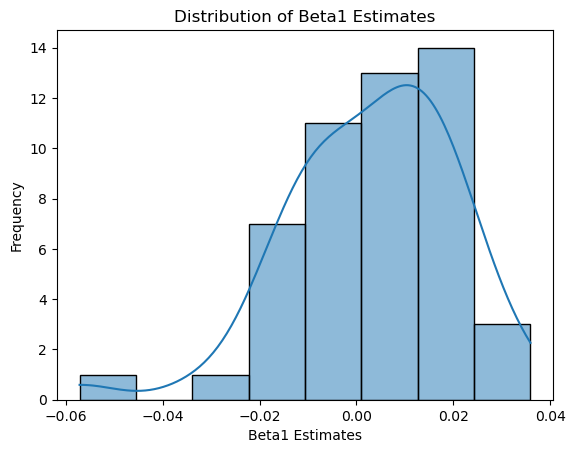

In [1]:
file_path = r'C:\Users\Biswajit Palit\Downloads\cps_00006.csv.gz'

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from cps_data_agg import process_cps_data

beta1_estimates = []
reject_count = 0  # Counter for the number of rejections
alpha = 0.05  # Significance level
rho = 0.2

bias_values = []

N = 50
T = 20
true_beta1_value = 0.02 
squared_error_values = []
standard_error_values =[]
num_simulations = 50


for _ in range(num_simulations):
    data = process_cps_data(file_path)
    
    states = data['STATEFIP'].unique()
    

    # Randomly select half of the states to be in the treatment group
    
    treatment_states = np.random.choice(states, size=len(states)//2, replace=False)

    # Assign treatment year to each treatment state, staggered between 1985 and 1995
    treatment_years = np.random.choice(range(1985, 1995), size=len(treatment_states), replace=True)
    state_to_treatment_year = dict(zip(treatment_states, treatment_years))

    # Add a treatment column to the DataFrame
    data['TREATMENT'] = data.apply(lambda x: 1 if x['STATEFIP'] in treatment_states and x['YEAR'] >= state_to_treatment_year[x['STATEFIP']] else 0, axis=1)
    

    X = data[['STATEFIP_2', 'STATEFIP_4', 'TREATMENT',
       'STATEFIP_5', 'STATEFIP_6', 'STATEFIP_8', 'STATEFIP_9', 'STATEFIP_10',
       'STATEFIP_12', 'STATEFIP_13', 'STATEFIP_15', 'STATEFIP_16',
       'STATEFIP_17', 'STATEFIP_18', 'STATEFIP_19', 'STATEFIP_20',
       'STATEFIP_21', 'STATEFIP_22', 'STATEFIP_23', 'STATEFIP_24',
       'STATEFIP_25', 'STATEFIP_26', 'STATEFIP_27', 'STATEFIP_28',
       'STATEFIP_29', 'STATEFIP_30', 'STATEFIP_31', 'STATEFIP_32',
       'STATEFIP_33', 'STATEFIP_34', 'STATEFIP_35', 'STATEFIP_36',
       'STATEFIP_37', 'STATEFIP_38', 'STATEFIP_39', 'STATEFIP_40',
       'STATEFIP_41', 'STATEFIP_42', 'STATEFIP_44', 'STATEFIP_45',
       'STATEFIP_46', 'STATEFIP_47', 'STATEFIP_48', 'STATEFIP_49',
       'STATEFIP_50', 'STATEFIP_51', 'STATEFIP_53', 'STATEFIP_54',
       'STATEFIP_55', 'STATEFIP_56', 'YEAR_1981', 'YEAR_1982', 'YEAR_1983',
       'YEAR_1984', 'YEAR_1985', 'YEAR_1986', 'YEAR_1987', 'YEAR_1988',
       'YEAR_1989', 'YEAR_1990', 'YEAR_1991', 'YEAR_1992', 'YEAR_1993',
       'YEAR_1994', 'YEAR_1995', 'YEAR_1996', 'YEAR_1997', 'YEAR_1998',
       'YEAR_1999', 'YEAR_2000' ]] # plus any other control variables
    X = sm.add_constant(X)
    Y = data['Residuals'] # Replace 'outcome' with your dependent variable
    model = sm.OLS(Y, X).fit(cov_type='cluster', cov_kwds={'groups': data['STATEFIP'].astype(str)})

    bias = model.params['TREATMENT'] - true_beta1_value
    
    bias_values.append(bias)

    squared_error = (model.params['TREATMENT'] - true_beta1_value) ** 2

    
    standard_error = model.bse['TREATMENT']
    standard_error_values.append(standard_error)
    beta1_estimates.append(model.params['TREATMENT'])
    
    
    # Check if null hypothesis for beta1 is rejected
    if model.pvalues['TREATMENT'] < alpha:
        reject_count += 1


type1_error = reject_count / num_simulations

average_bias = np.mean(bias_values)
average_mse = np.mean(squared_error)   
average_rmse = np.sqrt(average_mse)  
average_standard_error = np.mean(standard_error_values)   

std_error_beta_distribution = np.std(beta1_estimates)


average_bias = np.mean(bias_values)
average_mse = np.mean(squared_error)


# Print the number of rejections
print(f"Number of times null hypothesis is rejected : {reject_count} out of {num_simulations} simulations")
print(f"Type 1 of the test: {type1_error * 100} %")
print(f"Bias for Coefficient of Treatment (True Value = {true_beta1_value}): {average_bias}")
print(f"MSE for Coefficient of Treatment (True Value = {true_beta1_value}): {average_mse}")

sns.histplot(beta1_estimates, kde=True)
plt.xlabel('Beta1 Estimates')
plt.ylabel('Frequency')
plt.title('Distribution of Beta1 Estimates')
plt.show()



